In [1]:
import sys
sys.path.append("../")
%load_ext autoreload
%autoreload 2

In [2]:
from enhancer.networks.esrgan_blocks import *

In [3]:
from enhancer.data.data_utils import *

In [4]:
from enhancer import *
from enhancer.utils import *
from torchvision.transforms.functional import to_tensor
import copy
class ImageSplitter:
    # key points:
    # Boarder padding and over-lapping img splitting to avoid the instability of edge value
    # Thanks Waifu2x's autorh nagadomi for suggestions (https://github.com/nagadomi/waifu2x/issues/238)

    def __init__(self, seg_size=48, scale_factor=2, boarder_pad_size=3):
        self.seg_size = seg_size
        self.scale_factor = scale_factor
        self.pad_size = boarder_pad_size
        self.height = 0
        self.width = 0
        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode="bilinear")

    def split_img_tensor(self, pil_img, scale_method=Image.BILINEAR, img_pad=0):
        # resize image and convert them into tensor
        img_tensor = to_tensor(pil_img).unsqueeze(0)
        img_tensor = nn.ReplicationPad2d(self.pad_size)(img_tensor)
        batch, channel, height, width = img_tensor.size()
        self.height = height
        self.width = width

        if scale_method is not None:
            img_up = pil_img.resize(
                (2 * pil_img.size[0], 2 * pil_img.size[1]), scale_method
            )
            img_up = to_tensor(img_up).unsqueeze(0)
            img_up = nn.ReplicationPad2d(self.pad_size * self.scale_factor)(img_up)

        patch_box = []
        # avoid the residual part is smaller than the padded size
        if (
            height % self.seg_size < self.pad_size
            or width % self.seg_size < self.pad_size
        ):
            self.seg_size += self.scale_factor * self.pad_size

        # split image into over-lapping pieces
        for i in range(self.pad_size, height, self.seg_size):
            for j in range(self.pad_size, width, self.seg_size):
                part = img_tensor[
                    :,
                    :,
                    (i - self.pad_size) : min(
                        i + self.pad_size + self.seg_size, height
                    ),
                    (j - self.pad_size) : min(j + self.pad_size + self.seg_size, width),
                ]
                if img_pad > 0:
                    part = nn.ZeroPad2d(img_pad)(part)
                if scale_method is not None:
                    # part_up = self.upsampler(part)
                    part_up = img_up[
                        :,
                        :,
                        self.scale_factor
                        * (i - self.pad_size) : min(
                            i + self.pad_size + self.seg_size, height
                        )
                        * self.scale_factor,
                        self.scale_factor
                        * (j - self.pad_size) : min(
                            j + self.pad_size + self.seg_size, width
                        )
                        * self.scale_factor,
                    ]

                    patch_box.append((part, part_up))
                else:
                    patch_box.append(part)
        return patch_box

    def merge_img_tensor(self, list_img_tensor):
        out = torch.zeros(
            (1, 3, self.height * self.scale_factor, self.width * self.scale_factor)
        )
        img_tensors = copy.copy(list_img_tensor)
        if self.scale_factor%2 !=0:
            rem = self.pad_size * 3
        else:
            rem = self.pad_size * 2
            
        pad_size = self.scale_factor * self.pad_size
        seg_size = self.scale_factor * self.seg_size
        height = self.scale_factor * self.height
        width = self.scale_factor * self.width
        for i in range(pad_size, height, seg_size):
            for j in range(pad_size, width, seg_size):
                part = img_tensors.pop(0)
                part = part[:, :, rem:-rem, rem:-rem]
                # might have error
                if len(part.size()) > 3:
                    _, _, p_h, p_w = part.size()
                    out[:, :, i : i + p_h, j : j + p_w] = part
                # out[:,:,
                # self.scale_factor*i:self.scale_factor*i+p_h,
                # self.scale_factor*j:self.scale_factor*j+p_w] = part
        out = out[:, :, rem:-rem, rem:-rem]
        return out


In [118]:

import requests
from io import  BytesIO
response = requests.get("https://images.unsplash.com/photo-1594230612513-24c4ca53e781?ixlib=rb-1.2.1&auto=format&fit=crop&w=1050&q=80")
img = Image.open(BytesIO(response.content))

In [119]:
img_splitter = ImageSplitter(seg_size=150, scale_factor=6, boarder_pad_size=1)

In [129]:
img_patches = img_splitter.split_img_tensor(img, scale_method=None, img_pad=0)

In [151]:

def crop_forward(x, model, shave=32):
    b, c, h, w = x.size()
    h_half, w_half = h // 2, w // 2

    h_size, w_size = h_half + shave - (h_half + shave) % 4, w_half + shave - (w_half + shave) % 4

    inputlist = [
        x[:, :, 0:h_size, 0:w_size],
        x[:, :, 0:h_size, (w - w_size):w],
        x[:, :, (h - h_size):h, 0:w_size],
        x[:, :, (h - h_size):h, (w - w_size):w]]

    outputlist = []
    for i in inputlist:
        print(i.size())
    with torch.no_grad():
        input_batch = torch.cat(inputlist, dim=0)
        output_batch = model(input_batch)
#         print(output_batch.size())
        outputlist.extend(output_batch.chunk(4, dim=0))
        output = torch.zeros((b,c,h*4,w*4))
        output[:, :, 0:h_half, 0:w_half] \
            = outputlist[0][:, :, 0:h_half, 0:w_half]
        output[:, :, 0:h_half, w_half:w] \
            = outputlist[1][:, :, 0:h_half, (w_size - w + w_half):w_size]
        output[:, :, h_half:h, 0:w_half] \
            = outputlist[2][:, :, (h_size - h + h_half):h_size, 0:w_half]
        output[:, :, h_half:h, w_half:w] \
            = outputlist[3][:, :, (h_size - h + h_half):h_size, (w_size - w + w_half):w_size]

    return output

In [125]:
# import tqdm
# out=[]
# for j,i in enumerate(tqdm.tqdm(img_patches)):
#             # print(j)
#     with torch.no_grad():
#         out.append(Interpolate(factor=6)(i.to(device)))

In [130]:
# img_upscale = img_splitter.merge_img_tensor(out)

In [149]:
ex = np.array(img).transpose(2,0,1)/255.
ex = torch.from_numpy(ex).unsqueeze(0).float().to(device)

In [154]:
img_upscale = crop_forward(ex,Interpolate(factor=4))

torch.Size([1, 3, 380, 556])
torch.Size([1, 3, 380, 556])
torch.Size([1, 3, 380, 556])
torch.Size([1, 3, 380, 556])


In [113]:
img_upscale.size()

torch.Size([1, 3, 4212, 6312])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


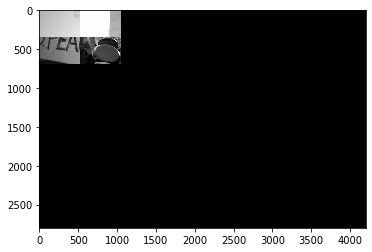

In [155]:
plt.imshow(im_convert(img_upscale,denormalize=False))

In [1]:
import sys
sys.path.append("../")
%load_ext autoreload
%autoreload 2

In [2]:
import enhancer.networks.imdn_blocks as B
import torch.nn as nn
from enhancer import *
class IMDN_SR(nn.Module):
    def __init__(self, in_nc=3, nf=64, num_modules=8, out_nc=3, upscale=4):
        super(IMDN_SR, self).__init__()

        fea_conv = [B.conv_layer(in_nc, nf, kernel_size=3)]
        rb_blocks = [B.IMDModule(in_channels=nf) for _ in range(num_modules)]
        LR_conv = B.conv_layer(nf, nf, kernel_size=3)

        upsample_block = B.pixelshuffle_block
        upsampler = upsample_block(nf, out_nc, upscale_factor=upscale)
        self.model = B.sequential(*fea_conv, B.ShortcutBlock(B.sequential(*rb_blocks, LR_conv)),
                                  *upsampler)

    def forward(self, input):
        output = self.model(input)
        return output
generator = IMDN_SR(upscale=4).to(device)

In [6]:
# generator(torch.randn(1,3,132,132).to(device)).shape

In [5]:
import sys
sys.path.append("../")
%load_ext autoreload
%autoreload 2
from enhancer.options import *
opt_path = "../configs/smallmodel/mse_train.yml"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dataloader = get_dataloader_from_yml(opt_path)

In [22]:
# for i in dataloader["train_dataloader"]:
#     print(i["lr"].shape)

In [7]:
getsample(dataloader["train_dataloader"])["lr"].size()

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


torch.Size([64, 3, 64, 64])

In [16]:
trainer = get_trainer_from_yml(opt_path,generator,dataloader["train_dataloader"])

In [18]:

def adjust_learning_rate(optimizer, epoch, step_size, lr_init, gamma):
    factor = epoch // step_size
    lr = lr_init * (gamma ** factor)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
trainer.train_model(1,1000)